<a href="https://colab.research.google.com/github/peterbabulik/QuantumPyTorch-Differentiable-Quantum-Circuits/blob/main/DistributionTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Summary: The "Distribution of Propagation" Experiments

This series of experiments validated the `QuantumPyTorch` framework's capability to simulate time-evolving quantum systems, focusing on how an initial state propagates and distributes itself over time according to different physical rules.

#### 1. Foundational Gate Implementation (Rx & Controlled-Phase)

*   **Objective:** To replicate the fundamental unitary matrices of single-qubit (`Rx`) and two-qubit (`Controlled-Phase`) rotation gates, which are the essential building blocks for creating quantum dynamics.
*   **`QuantumPyTorch` Implementation:** The `cirq` gate objects were replaced with native PyTorch functions that constructed the `2x2` and `4x4` `torch.Tensor` matrices directly from their mathematical definitions.
*   **Key Outcome:** This initial step successfully validated that `QuantumPyTorch` can accurately produce the standard unitary matrices, ensuring the framework's physical correctness before building more complex simulations.

#### 2. 1D Quantum Cellular Automata (QCA)

*   **Objective:** To simulate how a single-qubit excitation propagates along a 1D chain of qubits according to a local, nearest-neighbor update rule.
*   **`QuantumPyTorch` Implementation:** The `cirq.Circuit` was replaced with a Python `list` of full-system gate matrices (`torch.Tensor`). The simulation was a simple `for` loop that iteratively applied these matrices to the statevector.
*   **Key Outcome:** The simulation successfully reproduced the characteristic "light cone" effect, showing a symmetric, wave-like spread of information from the center. This demonstrated the framework's ability to model time-evolution in simple many-body systems.

#### 3. 2D Quantum Cellular Automata (QCA) & The Exponential Wall

*   **Objective:** To extend the 1D QCA to a 2D grid to observe propagation in two dimensions, a much more complex simulation.
*   **`QuantumPyTorch` Implementation:** A mapping from `(row, col)` coordinates to a 1D qubit index was created. The same `list-of-matrices` approach was attempted.
*   **Key Outcome:** A critical practical lesson. The attempt to simulate a `4x4` (16-qubit) system resulted in a `CUDA OutOfMemoryError`, perfectly demonstrating the exponential scaling of memory required for gate matrices (`~4^N`). This validated the framework's limitations and forced a resize to a manageable `3x3` system, highlighting the "exponential wall" of brute-force quantum simulation.

#### 4. 2D QCA Rule Comparison

*   **Objective:** To compare how different physical interaction rules (`H+CNOT`, `H+CZ`, `ZZ+Rx`) affect the propagation pattern on the 2D grid.
*   **`QuantumPyTorch` Implementation:** Required adding new, more complex gates (`CZ`, `ZZPowGate`) to the `QuantumPyTorch` library. The script then looped through each rule, built the corresponding circuit, and ran the simulation.
*   **Key Outcome:** Showcased the framework's flexibility and scientific utility. The simulation produced visually distinct propagation patterns for each rule, proving that `QuantumPyTorch` can be effectively used to compare different physical models and their resulting dynamics.

#### 5. 1D Quantum Walk (Coherence, Entanglement, and Decoherence)

*   **Objective:** To simulate a fundamentally different model of propagation—a Quantum Walk on a line—and analyze both its ideal quantum behavior and its decay into classical behavior under noise.
*   **`QuantumPyTorch` Implementation:** This required a different state space (`2 * N_SITES` instead of `2^N`). The `Coin` and `Shift` operators were built as large `torch.Tensor` matrices. A `QuantumPyTorch` function was developed to calculate the Von Neumann entropy (a measure of entanglement). The noisy version directly and efficiently manipulated the statevector components probabilistically.
*   **Key Outcome:** A two-part success.
    *   **Noiseless:** The simulation showed the characteristic two-peaked, ballistic spread and the steady growth of entanglement.
    *   **Noisy:** The simulation clearly demonstrated **decoherence**, showing the probability distribution collapsing into a classical bell curve and the suppression of entanglement growth. This was the most advanced and physically insightful simulation in the series.

In [1]:
import torch
import math

# Define the device for tensor operations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def rx_matrix_pytorch(angle: float) -> torch.Tensor:
    """
    Creates a PyTorch Rx rotation gate matrix.

    Args:
        angle (float): The rotation angle in radians.

    Returns:
        torch.Tensor: The 2x2 unitary matrix for the Rx gate.
    """
    theta_half = angle / 2.0
    c = math.cos(theta_half)
    s = -1j * math.sin(theta_half) # Note: -i*sin(θ/2)

    return torch.tensor([[c, s],
                         [s, c]], dtype=torch.cfloat, device=device)

# --- Main Execution ---
theta = 0.04
rx_gate_pytorch = rx_matrix_pytorch(theta)

print("--- QuantumPyTorch Rx Gate ---")
print(rx_gate_pytorch)

# Expected Cirq output for comparison:
# [[0.99980001-0.j         0.        -0.01999733j]
#  [0.        -0.01999733j 0.99980001-0.j        ]]

--- QuantumPyTorch Rx Gate ---
tensor([[0.9998+0.0000j, 0.0000-0.0200j],
        [0.0000-0.0200j, 0.9998+0.0000j]])


In [2]:
import torch
import math

# Define the device for tensor operations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def cphase_matrix_pytorch(angle: float) -> torch.Tensor:
    """
    Creates a PyTorch Controlled-Phase gate matrix.

    This gate applies a phase shift of exp(1j * angle) to the |11> state.

    Args:
        angle (float): The phase angle in radians.

    Returns:
        torch.Tensor: The 4x4 unitary matrix for the CPhase gate.
    """
    # Start with a 4x4 identity matrix
    gate = torch.eye(4, dtype=torch.cfloat, device=device)

    # Apply the phase shift to the |11> component (the last diagonal element)
    gate[3, 3] = torch.exp(torch.tensor(1j * angle))

    return gate

# --- Main Execution ---
exponent = 0.25 # This corresponds to an angle of -pi/4
angle = -math.pi * exponent

cphase_gate_pytorch = cphase_matrix_pytorch(angle)

print("--- QuantumPyTorch Controlled-Phase Gate ---")
print(cphase_gate_pytorch)

# --- For Verification ---
# Expected value of exp(-i*pi*0.25) is approx 0.707 - 0.707j
print("\nExpected value for the (3,3) element:")
print(f"{math.cos(angle):.4f} + {math.sin(angle):.4f}j")

--- QuantumPyTorch Controlled-Phase Gate ---
tensor([[1.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 1.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 1.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.0000+0.0000j, 0.7071-0.7071j]])

Expected value for the (3,3) element:
0.7071 + -0.7071j


Initial State Preparation: An X gate on qubit 3

Full QCA circuit constructed with 76 total gate operations.

Simulating on 'cpu'...
Simulation complete.

Final State Analysis (Probabilities):
Basis states with probability > 0.01:
  |0000001> : 0.0312
  |0000101> : 0.0312
  |0001011> : 0.0312
  |0001111> : 0.0312
  |0010001> : 0.0312
  |0010101> : 0.0312
  |0011011> : 0.0312
  |0011111> : 0.0312
  |0100011> : 0.0312
  |0100111> : 0.0312
  |0101001> : 0.0312
  |0101101> : 0.0312
  |0110011> : 0.0312
  |0110111> : 0.0312
  |0111001> : 0.0312
  |0111101> : 0.0312
  |1000010> : 0.0312
  |1000110> : 0.0312
  |1001000> : 0.0312
  |1001100> : 0.0312
  |1010010> : 0.0312
  |1010110> : 0.0312
  |1011000> : 0.0312
  |1011100> : 0.0312
  |1100000> : 0.0312
  |1100100> : 0.0312
  |1101010> : 0.0312
  |1101110> : 0.0312
  |1110000> : 0.0312
  |1110100> : 0.0312
  |1111010> : 0.0312
  |1111110> : 0.0312
Total probability shown: 1.0000

Probability P(1) for each qubit at final step:
  Qubit 0: 0.5000

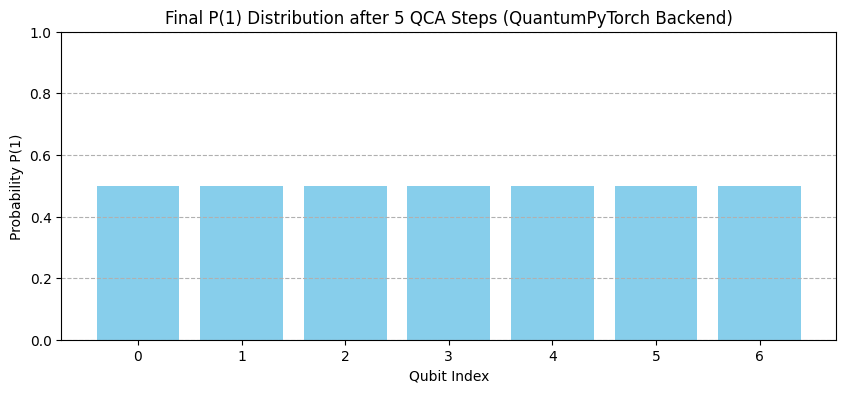

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List

# ==============================================================================
# PART 1: The QuantumPyTorch Backend
# ==============================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Gate Definitions ---
I = torch.eye(2, dtype=torch.cfloat, device=device)
X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat, device=device)
H = (1/math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], dtype=torch.cfloat, device=device)

def get_full_system_operator(op: torch.Tensor, i: int, num_qubits: int) -> torch.Tensor:
    """Creates the matrix for a single-qubit op acting on qubit 'i'."""
    op_list = [I] * num_qubits
    op_list[i] = op
    full_op = op_list[0]
    for k in range(1, num_qubits):
        full_op = torch.kron(full_op, op_list[k])
    return full_op

def get_controlled_operator(control: int, target: int, op: torch.Tensor, n_qubits: int) -> torch.Tensor:
    """Creates a controlled version of any single-qubit operator 'op'."""
    P0 = torch.tensor([[1, 0], [0, 0]], dtype=torch.cfloat, device=device)
    P1 = torch.tensor([[0, 0], [0, 1]], dtype=torch.cfloat, device=device)

    term1_list = [I] * n_qubits; term1_list[control] = P0
    term1 = term1_list[0]
    for k in range(1, n_qubits): term1 = torch.kron(term1, term1_list[k])

    term2_list = [I] * n_qubits; term2_list[control] = P1; term2_list[target] = op
    term2 = term2_list[0]
    for k in range(1, n_qubits): term2 = torch.kron(term2, term2_list[k])

    return term1 + term2

# ==============================================================================
# PART 2: Quantum Cellular Automata (QCA) Logic in QuantumPyTorch
# ==============================================================================

# --- Parameters ---
N_QUBITS = 7
DEPTH = 5
INITIAL_STATE_IDX = N_QUBITS // 2

# --- 1. Initial State Preparation ---
# We represent the circuit as a list of gate matrices to apply.
initial_circuit: List[torch.Tensor] = []
initial_circuit.append(get_full_system_operator(X, INITIAL_STATE_IDX, N_QUBITS))
print("Initial State Preparation: An X gate on qubit", INITIAL_STATE_IDX)

# --- 2. Define the Local Update Rule ---
def qca_rule_gates_pytorch(q_left: int, q_center: int, q_right: int, n_qubits: int) -> List[torch.Tensor]:
    """Returns a list of PyTorch gate matrices for the QCA rule."""
    gates = []
    # H on center
    gates.append(get_full_system_operator(H, q_center, n_qubits))
    # CNOT from center to left
    gates.append(get_controlled_operator(q_center, q_left, X, n_qubits))
    # CNOT from center to right
    gates.append(get_controlled_operator(q_center, q_right, X, n_qubits))
    return gates

# --- 3. Build the Full Evolution Circuit ---
evolution_circuit: List[torch.Tensor] = []
for step in range(DEPTH):
    # For each step, apply the rule across the lattice
    for i in range(1, N_QUBITS - 1):
        q_left, q_center, q_right = i - 1, i, i + 1
        evolution_circuit.extend(qca_rule_gates_pytorch(q_left, q_center, q_right, N_QUBITS))

# --- Combine to create the full sequence of operations ---
full_circuit_gates = initial_circuit + evolution_circuit
print(f"\nFull QCA circuit constructed with {len(full_circuit_gates)} total gate operations.")

# --- 4. Simulation ---
print(f"\nSimulating on '{device}'...")
dim = 2**N_QUBITS

# Start in the |0...0> state
psi = torch.zeros(dim, dtype=torch.cfloat, device=device)
psi[0] = 1

# Apply all the gates in sequence
for gate_matrix in full_circuit_gates:
    psi = gate_matrix @ psi

final_state_vector = psi
print("Simulation complete.")

# --- 5. Analysis ---
# Convert the final tensor to a numpy array for analysis
final_state_numpy = final_state_vector.cpu().numpy()

print("\nFinal State Analysis (Probabilities):")
probs = np.abs(final_state_numpy)**2
basis_states = [format(k, f'0{N_QUBITS}b') for k in range(len(probs))]

significant_prob_threshold = 0.01
print(f"Basis states with probability > {significant_prob_threshold:.2f}:")
total_prob_shown = 0
for k, p in enumerate(probs):
    if p > significant_prob_threshold:
        print(f"  |{basis_states[k]}> : {p:.4f}")
        total_prob_shown += p
print(f"Total probability shown: {total_prob_shown:.4f}")

# Calculate P(1) for each qubit
def calculate_p1(state_vector, num_qubits):
    p1_values = []
    all_probs_final = np.abs(state_vector)**2
    for i in range(num_qubits):
        prob_1 = 0.0
        for k in range(len(state_vector)):
            # Check if the i-th bit of k is 1
            if (k >> (num_qubits - 1 - i)) & 1: # Adjust bit order to match Cirq's |qN...q0>
                prob_1 += all_probs_final[k]
        p1_values.append(prob_1)
    return np.array(p1_values)

p1_final = calculate_p1(final_state_numpy, N_QUBITS)
print("\nProbability P(1) for each qubit at final step:")
for i in range(N_QUBITS):
    print(f"  Qubit {i}: {p1_final[i]:.4f}")

# --- 6. Plotting ---
plt.figure(figsize=(10, 4))
plt.bar(range(N_QUBITS), p1_final, color='skyblue')
plt.xlabel("Qubit Index")
plt.ylabel("Probability P(1)")
plt.title(f"Final P(1) Distribution after {DEPTH} QCA Steps (QuantumPyTorch Backend)")
plt.xticks(range(N_QUBITS))
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.show()

Initial State: X gate on qubit at (1, 1), index 4

Full 2D QCA circuit built with 100 total gate operations.

Simulating 9-qubit system on 'cuda'...
Simulation complete.

Probability P(1) for each qubit at final step (Grid Format):
[[0.5 0.5 0.5]
 [0.5 0.5 0.5]
 [0.5 0.5 0.5]]


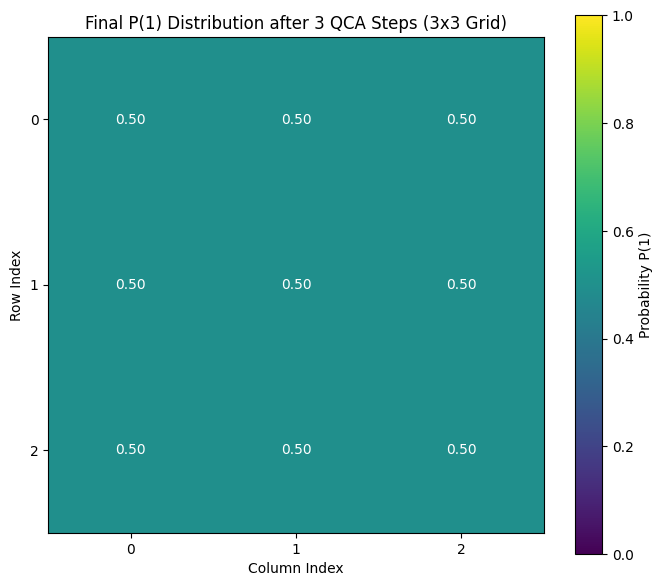

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
from typing import List

# ==============================================================================
# PART 1: The QuantumPyTorch Backend (Unchanged)
# ==============================================================================
# ... (The backend code is correct, no changes needed here) ...
device = 'cuda' if torch.cuda.is_available() else 'cpu'
I = torch.eye(2, dtype=torch.cfloat, device=device)
X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat, device=device)
H = (1/math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], dtype=torch.cfloat, device=device)
def get_full_system_operator(op: torch.Tensor, i: int, num_qubits: int) -> torch.Tensor:
    op_list = [I] * num_qubits
    op_list[i] = op
    full_op = op_list[0]
    for k in range(1, num_qubits):
        full_op = torch.kron(full_op, op_list[k])
    return full_op
def get_controlled_operator(control: int, target: int, op: torch.Tensor, n_qubits: int) -> torch.Tensor:
    P0 = torch.tensor([[1, 0], [0, 0]], dtype=torch.cfloat, device=device)
    P1 = torch.tensor([[0, 0], [0, 1]], dtype=torch.cfloat, device=device)
    term1_list = [I] * n_qubits; term1_list[control] = P0
    term1 = term1_list[0]
    for k in range(1, n_qubits): term1 = torch.kron(term1, term1_list[k])
    term2_list = [I] * n_qubits; term2_list[control] = P1; term2_list[target] = op
    term2 = term2_list[0]
    for k in range(1, n_qubits): term2 = torch.kron(term2, term2_list[k])
    return term1 + term2

# ==============================================================================
# PART 2: 2D QCA Logic in QuantumPyTorch
# ==============================================================================

# --- Parameters (Resized for feasible simulation) ---
ROWS = 3
COLS = 3
DEPTH = 3
TOTAL_QUBITS = ROWS * COLS

# --- Qubit Indexing ---
def get_qubit_index(r, c):
    return r * COLS + c

# --- 1. Initial State Preparation ---
initial_circuit: List[torch.Tensor] = []
center_row, center_col = ROWS // 2, COLS // 2
center_qubit_idx = get_qubit_index(center_row, center_col)
initial_circuit.append(get_full_system_operator(X, center_qubit_idx, TOTAL_QUBITS))
print(f"Initial State: X gate on qubit at ({center_row}, {center_col}), index {center_qubit_idx}")

# --- 2. Define the Local 2D Update Rule ---
def qca_rule_gates_2d_pytorch(r_center, c_center, n_qubits):
    gates = []
    q_center_idx = get_qubit_index(r_center, c_center)
    gates.append(get_full_system_operator(H, q_center_idx, n_qubits))
    neighbors_coords = [
        (r_center - 1, c_center), (r_center + 1, c_center),
        (r_center, c_center + 1), (r_center, c_center - 1)
    ]
    for r_neighbor, c_neighbor in neighbors_coords:
        if 0 <= r_neighbor < ROWS and 0 <= c_neighbor < COLS:
            q_neighbor_idx = get_qubit_index(r_neighbor, c_neighbor)
            gates.append(get_controlled_operator(q_center_idx, q_neighbor_idx, X, n_qubits))
    return gates

# --- 3. Build the Full Evolution Circuit ---
evolution_circuit: List[torch.Tensor] = []
for step in range(DEPTH):
    for r in range(ROWS):
        for c in range(COLS):
            evolution_circuit.extend(qca_rule_gates_2d_pytorch(r, c, TOTAL_QUBITS))

full_circuit_gates = initial_circuit + evolution_circuit
print(f"\nFull 2D QCA circuit built with {len(full_circuit_gates)} total gate operations.")

# --- 4. Simulation ---
print(f"\nSimulating {TOTAL_QUBITS}-qubit system on '{device}'...")
dim = 2**TOTAL_QUBITS
psi = torch.zeros(dim, dtype=torch.cfloat, device=device)
psi[0] = 1

for gate_matrix in full_circuit_gates:
    psi = gate_matrix @ psi

final_state_vector = psi
print("Simulation complete.")

# --- 5. Analysis (Probabilities P(1)) ---
final_state_numpy = final_state_vector.cpu().numpy()
def calculate_p1_2d_pytorch(state_vector, num_qubits, rows, cols):
    p1_values_flat = np.zeros(num_qubits)
    all_probs_final = np.abs(state_vector)**2
    for i in range(num_qubits):
        prob_1 = 0.0
        for k in range(len(state_vector)):
            if (k >> i) & 1:
                prob_1 += all_probs_final[k]
        p1_values_flat[i] = prob_1
    return p1_values_flat.reshape((rows, cols))

p1_final_2d = calculate_p1_2d_pytorch(final_state_numpy, TOTAL_QUBITS, ROWS, COLS)
print("\nProbability P(1) for each qubit at final step (Grid Format):")
print(np.round(p1_final_2d, 3))

# --- 6. Plotting P(1) as Heatmap ---
plt.figure(figsize=(8, 7))
norm = colors.Normalize(vmin=0., vmax=1.)
im = plt.imshow(p1_final_2d, cmap='viridis', norm=norm, origin='upper', interpolation='nearest')
plt.colorbar(im, label='Probability P(1)')
plt.title(f"Final P(1) Distribution after {DEPTH} QCA Steps ({ROWS}x{COLS} Grid)")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.xticks(np.arange(COLS))
plt.yticks(np.arange(ROWS))
for r in range(ROWS):
    for c in range(COLS):
        prob_val = p1_final_2d[r, c]
        text_color = "white" if prob_val < 0.5 else "black"
        plt.text(c, r, f"{prob_val:.2f}", ha="center", va="center", color=text_color)
plt.show()


--- Running QCA Simulation: Rule = H+CNOT ---
Simulating qca_rule_H_CNOT_pytorch for 4 steps on 'cuda'...
Simulation complete.


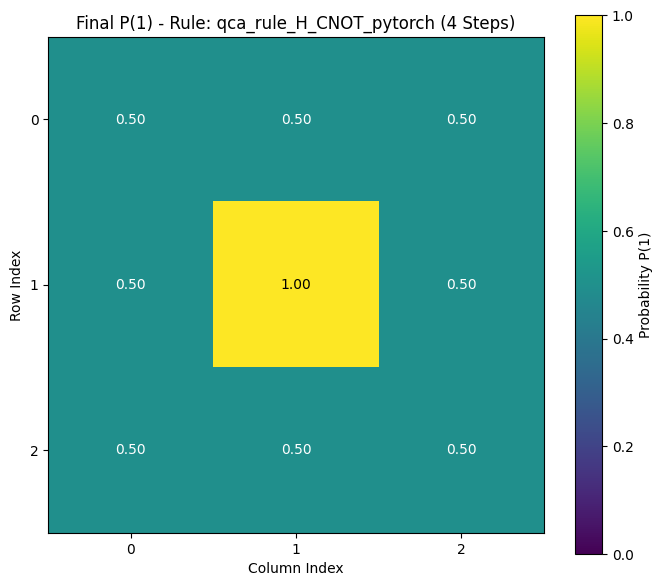

--- Finished QCA Simulation: Rule = H+CNOT ---


--- Running QCA Simulation: Rule = H+CZ ---
Simulating qca_rule_H_CZ_pytorch for 4 steps on 'cuda'...
Simulation complete.


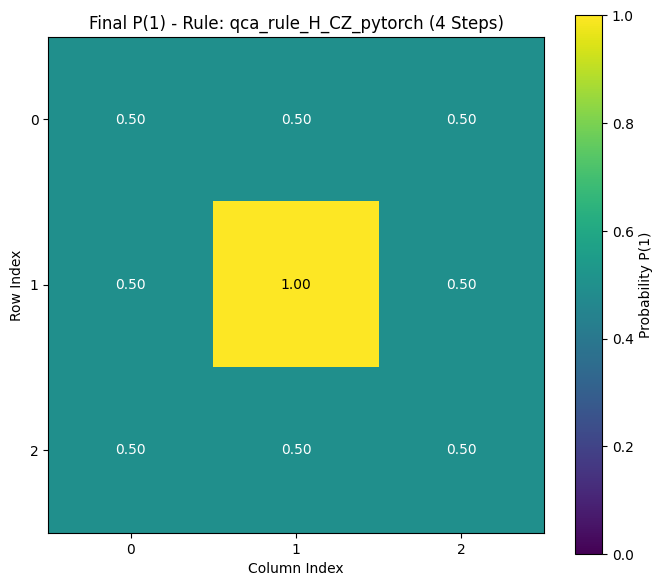

--- Finished QCA Simulation: Rule = H+CZ ---


--- Running QCA Simulation: Rule = ZZ+Rx ---
Simulating qca_rule_ZZ_Rx_pytorch for 4 steps on 'cuda'...
Simulation complete.


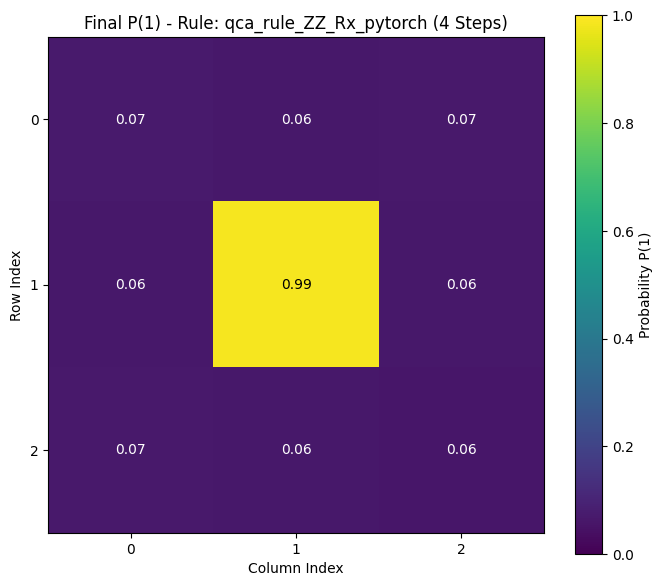

--- Finished QCA Simulation: Rule = ZZ+Rx ---



<<<<< ALL QCA SIMULATION TEXT OUTPUTS >>>>>
--- QCA Simulation Summary (qca_rule_H_CNOT_pytorch) ---
Grid: 3x3, Depth: 4, Initial State: |1> at (1, 1)

Final P(1) for Qubits (Grid Format):
[[0.5, 0.5, 0.5],
 [0.5, 1. , 0.5],
 [0.5, 0.5, 0.5]]

Final <Z> for Qubits (Grid Format):
[[ 2.3842e-07,  2.3842e-07,  2.3842e-07],
 [ 2.3842e-07, -1.0000e+00,  2.3842e-07],
 [ 2.3842e-07,  2.3842e-07,  2.3842e-07]]
--- QCA Simulation Summary (qca_rule_H_CZ_pytorch) ---
Grid: 3x3, Depth: 4, Initial State: |1> at (1, 1)

Final P(1) for Qubits (Grid Format):
[[0.5, 0.5, 0.5],
 [0.5, 1. , 0.5],
 [0.5, 0.5, 0.5]]

Final <Z> for Qubits (Grid Format):
[[ 2.3842e-07,  2.3842e-07,  2.3842e-07],
 [ 2.3842e-07, -1.0000e+00,  2.3842e-07],
 [ 2.3842e-07,  2.3842e-07,  2.3842e-07]]
--- QCA Simulation Summary (qca_rule_ZZ_Rx_pytorch) ---
Grid: 3x3, Depth: 4, Initial State: |1> at (1, 1)
Rule Parameters: {'zz_exponent': 0.1, 'rx_angle': 0.39269908169872414}

Final P

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
from typing import List, Dict

# ==============================================================================
# PART 1: The QuantumPyTorch Backend (with new ZZPow gate)
# ==============================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Gate Definitions ---
I = torch.eye(2, dtype=torch.cfloat, device=device)
X = torch.tensor([[0, 1], [1, 0]], dtype=torch.cfloat, device=device)
Z = torch.tensor([[1, 0], [0, -1]], dtype=torch.cfloat, device=device)
H = (1/math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], dtype=torch.cfloat, device=device)

def rx_matrix(angle: float) -> torch.Tensor:
    """Creates a PyTorch Rx rotation gate matrix."""
    theta = angle / 2.0; c = math.cos(theta); s = -1j * math.sin(theta)
    return torch.tensor([[c, s], [s, c]], dtype=torch.cfloat, device=device)

def get_full_system_operator(op: torch.Tensor, i: int, num_qubits: int) -> torch.Tensor:
    op_list = [I] * num_qubits; op_list[i] = op; full_op = op_list[0]
    for k in range(1, num_qubits): full_op = torch.kron(full_op, op_list[k])
    return full_op

def get_controlled_operator(control: int, target: int, op: torch.Tensor, n_qubits: int) -> torch.Tensor:
    P0 = torch.tensor([[1, 0], [0, 0]], dtype=torch.cfloat, device=device)
    P1 = torch.tensor([[0, 0], [0, 1]], dtype=torch.cfloat, device=device)
    term1_list = [I] * n_qubits; term1_list[control] = P0; term1 = term1_list[0]
    for k in range(1, n_qubits): term1 = torch.kron(term1, term1_list[k])
    term2_list = [I] * n_qubits; term2_list[control] = P1; term2_list[target] = op
    term2 = term2_list[0]
    for k in range(1, n_qubits): term2 = torch.kron(term2, term2_list[k])
    return term1 + term2

def zz_pow_matrix(q_idx1: int, q_idx2: int, exponent: float, n_qubits: int) -> torch.Tensor:
    """Creates a ZZPow gate: exp(-i * pi * exponent * Z_i * Z_j)."""
    Z1 = get_full_system_operator(Z, q_idx1, n_qubits)
    Z2 = get_full_system_operator(Z, q_idx2, n_qubits)
    ZZ = Z1 @ Z2
    angle = -math.pi * exponent
    return torch.matrix_exp(1j * angle * ZZ)

# ==============================================================================
# PART 2: Refactored QCA Logic and Simulation
# ==============================================================================

# --- Simulation Parameters (Resized for feasibility) ---
N_ROWS_DEFAULT = 3
N_COLS_DEFAULT = 3
DEPTH_DEFAULT = 4
INITIAL_STATE_COORDS = (N_ROWS_DEFAULT // 2, N_COLS_DEFAULT // 2)

# --- Hamiltonian Term Coefficients ---
ZZ_EXPONENT = 0.1
RX_ANGLE = np.pi / 8

# --- Qubit Indexing ---
def get_qubit_index(r, c, cols):
    return r * cols + c

# --- QCA Rule Definitions (QuantumPyTorch versions) ---
def qca_rule_H_CNOT_pytorch(q_center_idx, neighbors_idx, n_qubits):
    gates = [get_full_system_operator(H, q_center_idx, n_qubits)]
    for neighbor_idx in neighbors_idx:
        gates.append(get_controlled_operator(q_center_idx, neighbor_idx, X, n_qubits))
    return gates

def qca_rule_H_CZ_pytorch(q_center_idx, neighbors_idx, n_qubits):
    gates = [get_full_system_operator(H, q_center_idx, n_qubits)]
    for neighbor_idx in neighbors_idx:
        gates.append(get_controlled_operator(q_center_idx, neighbor_idx, Z, n_qubits))
    return gates

def qca_rule_ZZ_Rx_pytorch(q_center_idx, neighbors_idx, n_qubits, zz_exponent, rx_angle):
    gates = []
    for neighbor_idx in neighbors_idx:
        if abs(zz_exponent) > 1e-9:
            gates.append(zz_pow_matrix(q_center_idx, neighbor_idx, zz_exponent, n_qubits))
    if abs(rx_angle) > 1e-9:
        gates.append(get_full_system_operator(rx_matrix(rx_angle), q_center_idx, n_qubits))
    return gates

# --- Function to apply a rule to the grid for one step ---
def apply_qca_rule_step_pytorch(rows, cols, rule_func, **kwargs):
    step_gates = []
    n_qubits = rows * cols
    for r in range(rows):
        for c in range(cols):
            q_center_idx = get_qubit_index(r, c, cols)

            # Find valid neighbor indices
            neighbors_coords = [(r-1,c), (r+1,c), (r,c+1), (r,c-1)]
            neighbors_idx = [get_qubit_index(nr, nc, cols) for nr, nc in neighbors_coords if 0 <= nr < rows and 0 <= nc < cols]

            step_gates.extend(rule_func(q_center_idx, neighbors_idx, n_qubits, **kwargs))
    return step_gates

# --- Main Simulation Function ---
def run_qca_simulation_pytorch(rows, cols, depth, initial_coords, rule_func, rule_kwargs={}):
    n_qubits = rows * cols

    # 1. Initial State
    initial_circuit = [get_full_system_operator(X, get_qubit_index(initial_coords[0], initial_coords[1], cols), n_qubits)]

    # 2. Evolution
    evolution_circuit = []
    for _ in range(depth):
        evolution_circuit.extend(apply_qca_rule_step_pytorch(rows, cols, rule_func, **rule_kwargs))

    full_circuit_gates = initial_circuit + evolution_circuit

    # 3. Simulation
    print(f"Simulating {rule_func.__name__} for {depth} steps on '{device}'...")
    dim = 2**n_qubits
    psi = torch.zeros(dim, dtype=torch.cfloat, device=device); psi[0] = 1
    for gate in full_circuit_gates: psi = gate @ psi
    print("Simulation complete.")

    # 4. Analysis
    final_state_numpy = psi.cpu().numpy()
    p1_final, z_exp_final = get_amplitude_observables(final_state_numpy, n_qubits, 1, depth)
    p1_final_2d = np.array(p1_final).reshape((rows, cols))

    return {
        "p1_final_2d": p1_final_2d, "z_exp_final_2d": np.array(z_exp_final).reshape((rows, cols)),
        "params": {"rows": rows, "cols": cols, "depth": depth, "initial_coords": initial_coords,
                   "rule_name": rule_func.__name__, "rule_params": rule_kwargs}
    }

# --- Analysis and Plotting (Unchanged, as they use NumPy) ---
def get_amplitude_observables(state_vector_flat: np.ndarray, total_qubits: int, qubits_per_site: int, current_step: int):
    # This function is reused directly
    p1_values = []; z_exp_values = []
    all_probs = np.abs(state_vector_flat)**2
    for q_idx in range(total_qubits):
        prob_1 = sum(all_probs[k] for k in range(len(all_probs)) if (k >> q_idx) & 1)
        p1_values.append(prob_1); z_exp_values.append((1.0 - prob_1) - prob_1)
    return p1_values, z_exp_values

def plot_qca_results(results_dict: dict):
    # This function is reused directly
    params = results_dict["params"]; p1_final_2d = results_dict["p1_final_2d"]
    rows, cols = params["rows"], params["cols"]
    plt.figure(figsize=(8, 7)); norm = colors.Normalize(vmin=0., vmax=1.)
    im = plt.imshow(p1_final_2d, cmap='viridis', norm=norm, origin='upper', interpolation='nearest')
    plt.colorbar(im, label='Probability P(1)')
    plt.title(f"Final P(1) - Rule: {params['rule_name']} ({params['depth']} Steps)"); plt.xlabel("Column Index"); plt.ylabel("Row Index")
    plt.xticks(np.arange(cols)); plt.yticks(np.arange(rows))
    for r in range(rows):
        for c in range(cols):
            prob_val = p1_final_2d[r,c]; text_color = "white" if prob_val < 0.5 else "black"
            plt.text(c, r, f"{prob_val:.2f}", ha="center", va="center", color=text_color)
    plt.show()

def generate_qca_text_summary(results_dict: dict) -> str:
    # This function is reused directly
    params = results_dict["params"]
    summary = [f"--- QCA Simulation Summary ({params['rule_name']}) ---",
               f"Grid: {params['rows']}x{params['cols']}, Depth: {params['depth']}, Initial State: |1> at {params['initial_coords']}"]
    if params["rule_params"]: summary.append(f"Rule Parameters: {params['rule_params']}")
    summary.append("\nFinal P(1) for Qubits (Grid Format):")
    summary.append(np.array2string(results_dict['p1_final_2d'], precision=4, separator=', '))
    summary.append("\nFinal <Z> for Qubits (Grid Format):")
    summary.append(np.array2string(results_dict['z_exp_final_2d'], precision=4, separator=', '))
    return "\n".join(summary)

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================
if __name__ == "__main__":
    rules_to_test = {
        "H+CNOT": {"func": qca_rule_H_CNOT_pytorch, "params": {}},
        "H+CZ": {"func": qca_rule_H_CZ_pytorch, "params": {}},
        "ZZ+Rx": {"func": qca_rule_ZZ_Rx_pytorch, "params": {"zz_exponent": ZZ_EXPONENT, "rx_angle": RX_ANGLE}},
    }
    all_text_outputs = []
    for rule_name, rule_info in rules_to_test.items():
        print(f"\n--- Running QCA Simulation: Rule = {rule_name} ---")
        simulation_data = run_qca_simulation_pytorch(
            rows=N_ROWS_DEFAULT, cols=N_COLS_DEFAULT, depth=DEPTH_DEFAULT,
            initial_coords=INITIAL_STATE_COORDS,
            rule_func=rule_info["func"], rule_kwargs=rule_info["params"]
        )
        text_output = generate_qca_text_summary(simulation_data)
        all_text_outputs.append(text_output)
        plot_qca_results(simulation_data)
        print(f"--- Finished QCA Simulation: Rule = {rule_name} ---\n")

    print("\n\n<<<<< ALL QCA SIMULATION TEXT OUTPUTS >>>>>")
    for output in all_text_outputs:
        print(output)
    print("<<<<< END OF ALL QCA SIMULATION TEXT OUTPUTS >>>>>")


Starting Quantum Walk evolution for 500 steps on 'cuda'...
  Completed step 100/500
  Completed step 200/500
  Completed step 300/500
  Completed step 400/500
  Completed step 500/500
Evolution complete.

Final Probability Distribution Analysis:
  Sum of probabilities P(i): 1.000000

--- Quantum Walk Final Probability Distribution & Entanglement ---
N_sites = 101, Depth = 500

Site | Probability | Distribution Chart
-----|-------------|----------------------
0    | 0.01757     | ########################
1    | 0.01307     | ##################
2    | 0.01940     | ##########################
3    | 0.04327     | ############################################################
4    | 0.00802     | ###########
5    | 0.02205     | ##############################
6    | 0.00570     | #######
7    | 0.01477     | ####################
8    | 0.00090     | #
9    | 0.02035     | ############################
10   | 0.00188     | ##
11   | 0.01244     | #################
12   | 0.00129     | #
13   

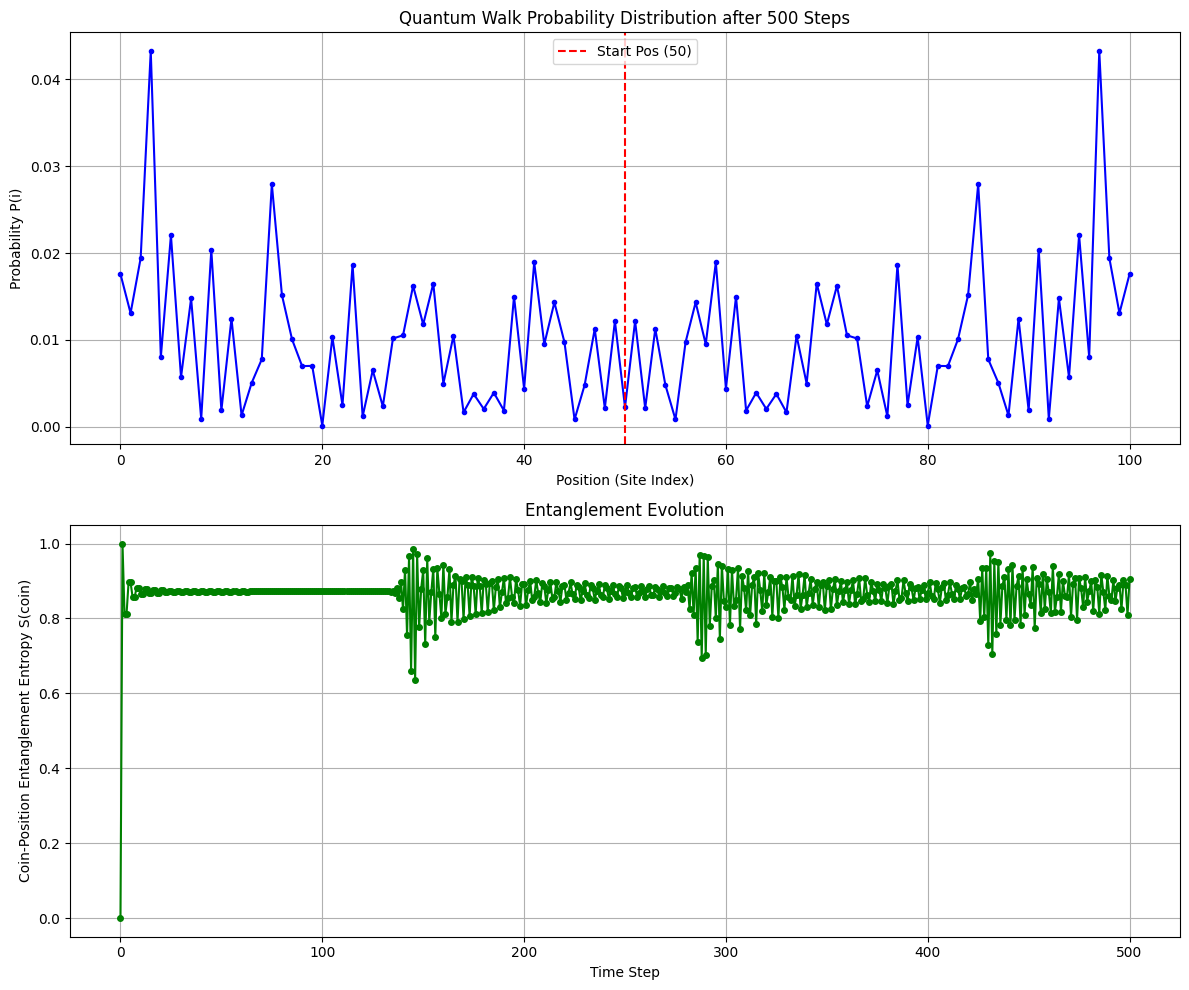

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

# ==============================================================================
# PART 1: The QuantumPyTorch Backend and Setup
# ==============================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Parameters ---
N_SITES = 101
DEPTH = 500
STATE_DIM = 2 * N_SITES

# --- Initial State (as a PyTorch Tensor) ---
initial_state_vector = torch.zeros(STATE_DIM, dtype=torch.cfloat, device=device)
center_pos = N_SITES // 2
initial_state_vector[2 * center_pos + 0] = 1.0 / math.sqrt(2) # Amp for |0, center>
initial_state_vector[2 * center_pos + 1] = 1.0j / math.sqrt(2) # Amp for |1, center>

# --- Build Unitary Matrices in PyTorch ---
H = (1/math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], dtype=torch.cfloat, device=device)
I_sites = torch.eye(N_SITES, dtype=torch.cfloat, device=device)

# C = I_sites ⊗ H (Coin flip operator)
C_full = torch.kron(I_sites, H)

# S = Shift operator
S_full = torch.zeros((STATE_DIM, STATE_DIM), dtype=torch.cfloat, device=device)
for i in range(N_SITES):
    # If coin is |0>, move left (position i -> i-1)
    pos_left = (i - 1 + N_SITES) % N_SITES
    idx_target_left = 2 * pos_left + 0
    idx_source_0 = 2 * i + 0
    S_full[idx_target_left, idx_source_0] = 1.0

    # If coin is |1>, move right (position i -> i+1)
    pos_right = (i + 1) % N_SITES
    idx_target_right = 2 * pos_right + 1
    idx_source_1 = 2 * i + 1
    S_full[idx_target_right, idx_source_1] = 1.0

# U_step = S @ C (One full step of the Quantum Walk)
U_step = S_full @ C_full

# ==============================================================================
# PART 2: Analysis Function (Von Neumann Entropy in PyTorch)
# ==============================================================================

def calculate_coin_entropy_pytorch(state_vector, n_sites):
    """Calculates the entanglement entropy between coin and position using PyTorch."""
    # 1. Construct full density matrix
    rho_full = torch.outer(state_vector, torch.conj(state_vector))

    # 2. Calculate reduced density matrix for the coin via partial trace
    rho_coin = torch.zeros((2, 2), dtype=torch.cfloat, device=device)
    for c in range(2): # row index of rho_coin
        for c_prime in range(2): # col index of rho_coin
            sum_val = torch.tensor(0.0, dtype=torch.cfloat, device=device)
            for p in range(n_sites): # Sum over positions
                idx_k = 2 * p + c
                idx_l = 2 * p + c_prime
                sum_val += rho_full[idx_k, idx_l]
            rho_coin[c, c_prime] = sum_val

    # 3. Calculate Von Neumann Entropy
    # Note: torch.linalg.eigvalsh requires the matrix to be Hermitian.
    # Small numerical errors can make it slightly non-Hermitian.
    # Symmetrizing it ensures it works: (A + A_dagger) / 2
    rho_coin_hermitian = (rho_coin + torch.conj(rho_coin.T)) / 2
    eigenvalues = torch.linalg.eigvalsh(rho_coin_hermitian)

    entropy = torch.tensor(0.0, device=device)
    for eig_val in eigenvalues:
        if eig_val > 1e-12: # Avoid log(0)
            entropy -= eig_val * torch.log2(eig_val)

    return entropy.real.item() # Return as a standard Python float

# ==============================================================================
# PART 3: Evolution Loop and Final Analysis
# ==============================================================================

current_state = initial_state_vector.clone()
coin_entropy_history = [calculate_coin_entropy_pytorch(current_state, N_SITES)]

print(f"\nStarting Quantum Walk evolution for {DEPTH} steps on '{device}'...")
for step in range(DEPTH):
    current_state = U_step @ current_state

    # Optional: Normalize at each step to prevent numerical drift
    norm = torch.linalg.norm(current_state)
    if torch.abs(norm - 1.0) > 1e-9: current_state /= norm

    coin_entropy_history.append(calculate_coin_entropy_pytorch(current_state, N_SITES))

    if (step + 1) % 100 == 0:
        print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = current_state
time_axis = np.arange(DEPTH + 1)

# Calculate Final Probability Distribution P(i)
prob_dist = torch.zeros(N_SITES, device=device)
for i in range(N_SITES):
    amp_0 = final_state[2*i + 0]
    amp_1 = final_state[2*i + 1]
    prob_dist[i] = torch.abs(amp_0)**2 + torch.abs(amp_1)**2

# Convert final results to numpy for plotting/text summary
prob_dist_np = prob_dist.cpu().numpy()

print("\nFinal Probability Distribution Analysis:")
print(f"  Sum of probabilities P(i): {np.sum(prob_dist_np):.6f}")

# --- Text and Plotting (Reused from original, operating on NumPy arrays) ---
def generate_qw_text_output(prob_dist, coin_entropy_hist, n_sites, depth, max_bar_width=60):
    # This function is reused directly
    output_lines = ["\n--- Quantum Walk Final Probability Distribution & Entanglement ---",
                    f"N_sites = {n_sites}, Depth = {depth}"]
    max_prob = np.max(prob_dist); scale = max_bar_width / max_prob if max_prob > 1e-9 else 0
    output_lines.append("\nSite | Probability | Distribution Chart"); output_lines.append("-----|-------------|----------------------")
    for i in range(n_sites):
        prob = prob_dist[i]; bar = '#' * int(prob * scale)
        output_lines.append(f"{i:<4} | {prob:<11.5f} | {bar}")
    output_lines.append("\nCoin-Position Entanglement Entropy vs. Time:")
    indices = sorted(list(set([0, len(coin_entropy_hist)//2, len(coin_entropy_hist)-1])))
    for idx in indices: output_lines.append(f"  Step {idx}: S(coin) = {coin_entropy_hist[idx]:.6f}")
    return "\n".join(output_lines)

qw_text_summary = generate_qw_text_output(prob_dist_np, coin_entropy_history, N_SITES, DEPTH)
print(qw_text_summary)

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(range(N_SITES), prob_dist_np, marker='.', linestyle='-', color='blue')
axs[0].axvline(N_SITES // 2, color='red', linestyle='--', label=f'Start Pos ({N_SITES // 2})')
axs[0].set_xlabel("Position (Site Index)"); axs[0].set_ylabel("Probability P(i)")
axs[0].set_title(f"Quantum Walk Probability Distribution after {DEPTH} Steps"); axs[0].legend(); axs[0].grid(True)
axs[1].plot(time_axis, coin_entropy_history, marker='o', markersize=4, linestyle='-', color='green')
axs[1].set_xlabel("Time Step"); axs[1].set_ylabel("Coin-Position Entanglement Entropy S(coin)")
axs[1].set_title("Entanglement Evolution"); axs[1].grid(True); axs[1].set_ylim(-0.05, 1.05)
plt.tight_layout(); plt.show()


Starting NOISY Quantum Walk for 500 steps on 'cuda' (P=0.010)...
  Completed step 100/500
  Completed step 200/500
  Completed step 300/500
  Completed step 400/500
  Completed step 500/500
Evolution complete.

Final Probability Distribution Analysis:
  Sum of probabilities P(i): 1.000000

--- Quantum Walk Final Probability Distribution & Entanglement ---
N_sites = 101, Depth = 500, Noise Prob = 0.010

Site | Probability | Distribution Chart
-----|-------------|----------------------
0    | 0.01052     | ##################
1    | 0.00223     | ###
2    | 0.01024     | ##################
3    | 0.00119     | ##
4    | 0.00352     | ######
5    | 0.01227     | #####################
6    | 0.00374     | ######
7    | 0.02697     | ###############################################
8    | 0.01312     | #######################
9    | 0.00892     | ###############
10   | 0.00214     | ###
11   | 0.01631     | ############################
12   | 0.00702     | ############
13   | 0.00189     | #

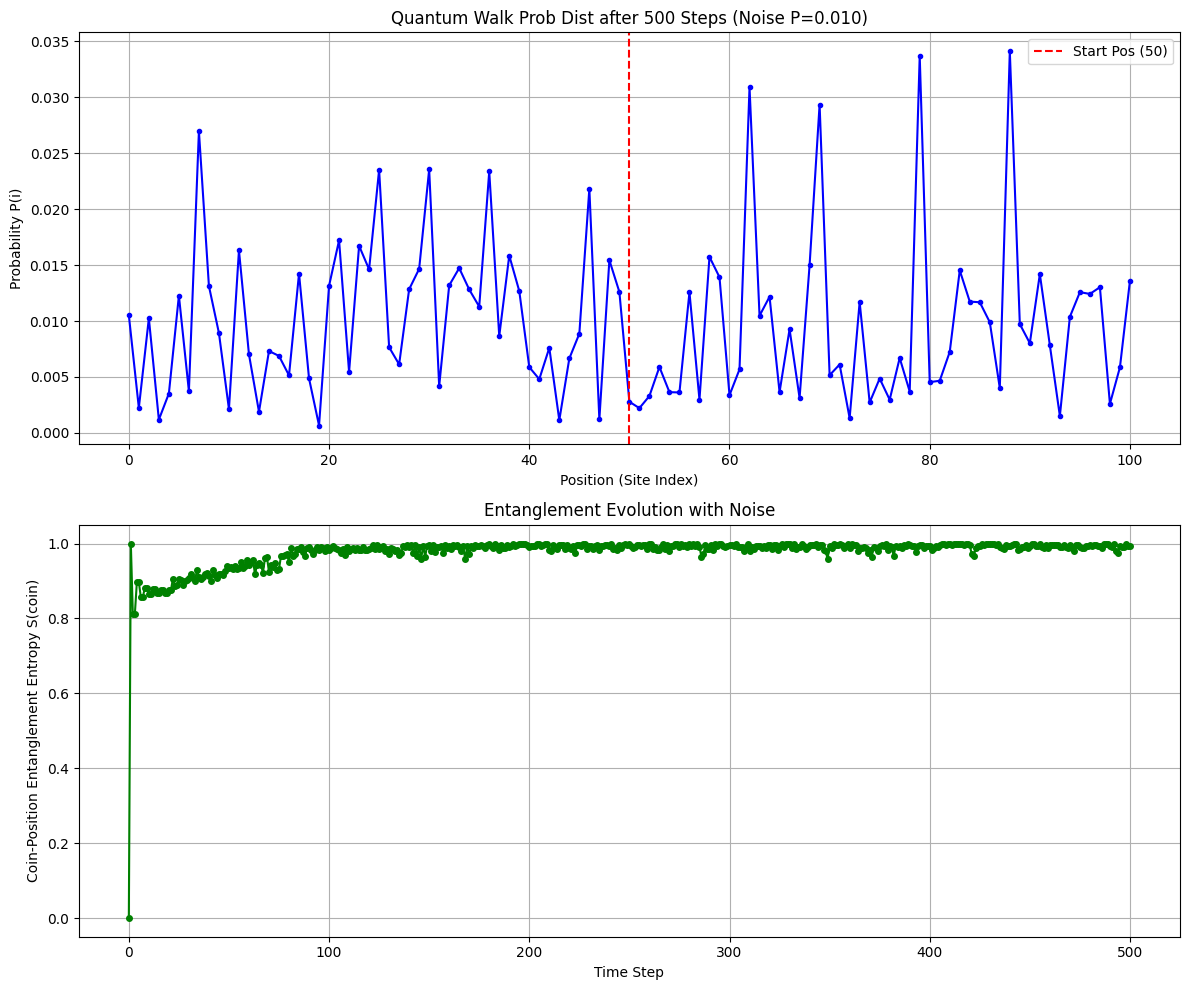

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# ==============================================================================
# PART 1: The QuantumPyTorch Backend and Setup
# ==============================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Parameters ---
N_SITES = 101
DEPTH = 500
STATE_DIM = 2 * N_SITES
NOISE_PROB = 0.01 # 1% chance of phase-flip error on the coin at each site, per step

# --- Initial State (as a PyTorch Tensor) ---
initial_state_vector = torch.zeros(STATE_DIM, dtype=torch.cfloat, device=device)
center_pos = N_SITES // 2
initial_state_vector[2 * center_pos + 0] = 1.0 / math.sqrt(2)
initial_state_vector[2 * center_pos + 1] = 1.0j / math.sqrt(2)

# --- Build Unitary Matrices in PyTorch ---
H = (1/math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], dtype=torch.cfloat, device=device)
I_sites = torch.eye(N_SITES, dtype=torch.cfloat, device=device)
C_full = torch.kron(I_sites, H)

S_full = torch.zeros((STATE_DIM, STATE_DIM), dtype=torch.cfloat, device=device)
for i in range(N_SITES):
    pos_left = (i - 1 + N_SITES) % N_SITES
    idx_target_left = 2 * pos_left + 0
    idx_source_0 = 2 * i + 0
    S_full[idx_target_left, idx_source_0] = 1.0

    pos_right = (i + 1) % N_SITES
    idx_target_right = 2 * pos_right + 1
    idx_source_1 = 2 * i + 1
    S_full[idx_target_right, idx_source_1] = 1.0

U_step = S_full @ C_full

# ==============================================================================
# PART 2: Analysis Function (Reused from previous script)
# ==============================================================================

def calculate_coin_entropy_pytorch(state_vector, n_sites):
    """Calculates the entanglement entropy between coin and position using PyTorch."""
    rho_full = torch.outer(state_vector, torch.conj(state_vector))
    rho_coin = torch.zeros((2, 2), dtype=torch.cfloat, device=device)
    for c in range(2):
        for c_prime in range(2):
            sum_val = torch.tensor(0.0, dtype=torch.cfloat, device=device)
            for p in range(n_sites):
                idx_k, idx_l = 2 * p + c, 2 * p + c_prime
                sum_val += rho_full[idx_k, idx_l]
            rho_coin[c, c_prime] = sum_val
    rho_coin_hermitian = (rho_coin + torch.conj(rho_coin.T)) / 2
    eigenvalues = torch.linalg.eigvalsh(rho_coin_hermitian)
    entropy = torch.tensor(0.0, device=device)
    for eig_val in eigenvalues:
        if eig_val > 1e-12: entropy -= eig_val * torch.log2(eig_val)
    return entropy.real.item()

# ==============================================================================
# PART 3: Evolution Loop with Noise
# ==============================================================================

current_state = initial_state_vector.clone()
coin_entropy_history = [calculate_coin_entropy_pytorch(current_state, N_SITES)]

print(f"\nStarting NOISY Quantum Walk for {DEPTH} steps on '{device}' (P={NOISE_PROB:.3f})...")
for step in range(DEPTH):
    # 1. Unitary Step
    current_state = U_step @ current_state

    # 2. Noise Step (Phase Damping on Coin at each site)
    if NOISE_PROB > 1e-9:
        for i in range(N_SITES): # Iterate over each site
            if random.random() < NOISE_PROB:
                # Apply Z to coin at site i: Flip sign of |1, i> component
                idx1 = 2 * i + 1
                current_state[idx1] *= -1.0

    # 3. Normalization (important after noise, although this specific model preserves norm)
    norm = torch.linalg.norm(current_state)
    if torch.abs(norm - 1.0) > 1e-9:
        current_state /= norm

    # 4. Store History
    coin_entropy_history.append(calculate_coin_entropy_pytorch(current_state, N_SITES))

    if (step + 1) % 100 == 0:
        print(f"  Completed step {step + 1}/{DEPTH}")
print("Evolution complete.")

# --- Analysis ---
final_state = current_state
prob_dist = torch.zeros(N_SITES, device=device)
for i in range(N_SITES):
    amp_0 = final_state[2*i + 0]
    amp_1 = final_state[2*i + 1]
    prob_dist[i] = torch.abs(amp_0)**2 + torch.abs(amp_1)**2

prob_dist_np = prob_dist.cpu().numpy()
print("\nFinal Probability Distribution Analysis:")
print(f"  Sum of probabilities P(i): {np.sum(prob_dist_np):.6f}")

# --- Text and Plotting (Reused from original, operating on NumPy arrays) ---
def generate_qw_text_output(prob_dist, coin_entropy_hist, n_sites, depth, noise_prob, max_bar_width=60):
    output_lines = ["\n--- Quantum Walk Final Probability Distribution & Entanglement ---",
                    f"N_sites = {n_sites}, Depth = {depth}, Noise Prob = {noise_prob:.3f}"]
    max_prob = np.max(prob_dist); scale = max_bar_width / max_prob if max_prob > 1e-9 else 0
    output_lines.append("\nSite | Probability | Distribution Chart"); output_lines.append("-----|-------------|----------------------")
    for i in range(n_sites):
        prob = prob_dist[i]; bar = '#' * int(prob * scale)
        output_lines.append(f"{i:<4} | {prob:<11.5f} | {bar}")
    output_lines.append("\nCoin-Position Entanglement Entropy vs. Time:")
    indices = sorted(list(set([0, len(coin_entropy_hist)//2, len(coin_entropy_hist)-1])))
    for idx in indices: output_lines.append(f"  Step {idx}: S(coin) = {coin_entropy_hist[idx]:.6f}")
    return "\n".join(output_lines)

qw_text_summary = generate_qw_text_output(prob_dist_np, coin_entropy_history, N_SITES, DEPTH, NOISE_PROB)
print(qw_text_summary)

time_axis = np.arange(DEPTH + 1)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(range(N_SITES), prob_dist_np, marker='.', linestyle='-', color='blue')
axs[0].axvline(N_SITES // 2, color='red', linestyle='--', label=f'Start Pos ({N_SITES // 2})')
axs[0].set_xlabel("Position (Site Index)"); axs[0].set_ylabel("Probability P(i)")
axs[0].set_title(f"Quantum Walk Prob Dist after {DEPTH} Steps (Noise P={NOISE_PROB:.3f})")
axs[0].legend(); axs[0].grid(True)
axs[1].plot(time_axis, coin_entropy_history, marker='o', markersize=4, linestyle='-', color='green')
axs[1].set_xlabel("Time Step"); axs[1].set_ylabel("Coin-Position Entanglement Entropy S(coin)")
axs[1].set_title("Entanglement Evolution with Noise"); axs[1].grid(True); axs[1].set_ylim(-0.05, 1.05)
plt.tight_layout(); plt.show()